# Galaxies Morphology Classification Using CNN

Using the Galaxy-Zoo dataset available on kaggle: https://www.kaggle.com/c/galaxy-zoo-the-galaxy-challenge/data,
we will exploit a Convolutional Neural Network to train a model for galaxy morphology classification.


In [ ]:
#Importing libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os, random, shutil
import tensorflow as tf
import seaborn
from tensorflow import keras
from tensorflow.keras import preprocessing, layers
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import image



## Introduction and data interpretation.


The dataset has been crowdsource-labeld and the data we are working on are labeled following that decision tree:

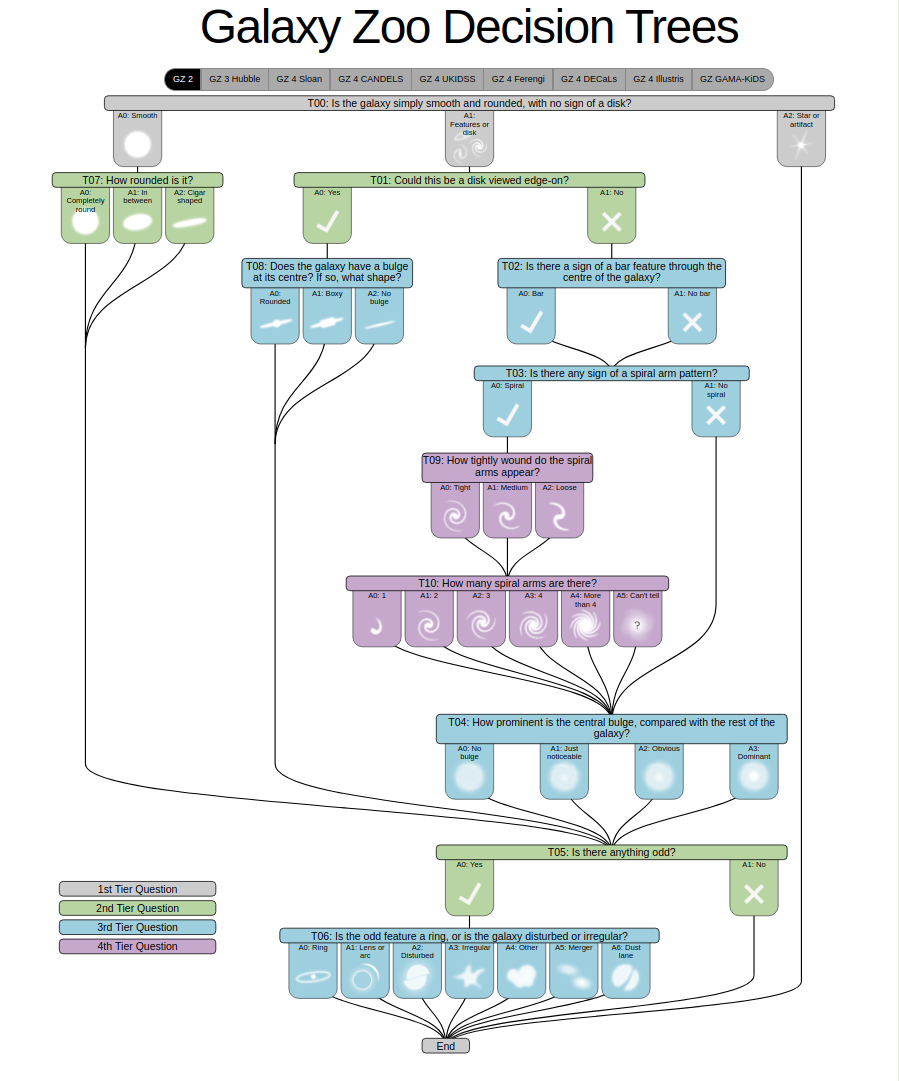






We will define 3 classes corresponding to galaxy morphologies sub-setting the decision tree:


Elliptical: Q1.1 > 0.8 and Q7.1 > 0.6 


Lenticular: Q1.1 > 0.8 and Q7.2 > 0.6  

Spiral : Q1.1 > 0.8 and Q7.3  > 0.6  


Cigar-shaped: Q1.1 > 0.8 and Q7.3 > 0.6 and Q8.3 < 0.2 (A Cigar shape is not so far away from a disk with no bulge.)




In [ ]:
#Set the base paths
base_path = r'../input/galaxy-zoo-the-galaxy-challenge/'
training_solutions = os.path.join(base_path, 'training_solutions_rev1.zip')
training_images    = os.path.join(base_path, 'images_training_rev1.zip')

Create the dataset and updating the columns names to match our notation.

In [ ]:

df = pd.read_csv(training_solutions, compression="zip")
cols = df.columns
new = list(map(lambda s: s.replace('Class','Q'), cols))
df.columns = new
df.head()

Create the class-substet of the database and visualizing the lenghts:

In [ ]:
ellipticals = df[(df['Q1.1']>0.7) & (df['Q7.1']>0.4)]['GalaxyID'].tolist()

lenticulars = df[(df['Q1.1']>0.7) & (df['Q7.2']>0.4)]['GalaxyID'].tolist()

spirals = df[(df['Q1.2']>0.7) & (df['Q2.1']>0.4)]['GalaxyID'].tolist()

print('Total number of elliptical examples: ',  len(ellipticals))
print('Total number of lenticular examples: ',  len(lenticulars))
print('Total number of spiral examples: ',  len(spirals))



Defining a function that will randomly select the training and validation images for each class and create subfolders:


In [ ]:
def _proc_images(src, dst, label, arr, percent):
    train_dir = os.path.join(dst, 'train')
    val_dir = os.path.join(dst, 'validation')
    
    train_dest = os.path.join(train_dir, label)
    val_dest   = os.path.join(val_dir, label)
    
    if not os.path.exists(train_dest):
        os.makedirs(train_dest)

    if not os.path.exists(val_dest):
        os.makedirs(val_dest)
    
    random.shuffle(arr)
    
    idx = int(len(arr)*percent)
    for i in arr[0:idx]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(train_dest, str(i)+'.jpg'))
    for i in arr[idx:]:
        shutil.copyfile(os.path.join(src, str(i)+'.jpg'), os.path.join(val_dest, str(i)+'.jpg'))
    
    print(label, 'done!')
    
    


In [ ]:
_proc_images(training_images, '../input/galaxy-zoo-clean/data/', 'elliptical', ellipticals, 0.80)
_proc_images(training_images,'../input/galaxy-zoo-clean/data/', 'lenticular', lenticulars, 0.80)
_proc_images(training_images, '../input/galaxy-zoo-clean/data/', 'spiral', spirals, 0.80)


print('Elliptical:', len(os.listdir(os.path.join(my_data, 'train', 'elliptical'))))
print('Total train lenticular:', len(os.listdir(os.path.join(my_data, 'train', 'lenticular'))))
print('Total train spiral:', len(os.listdir(os.path.join(my_data, 'train', 'spiral'))))


print('Total validation elliptical:', len(os.listdir(os.path.join(my_data, 'validation', 'elliptical'))))
print('Total validation lenticular:', len(os.listdir(os.path.join(my_data, 'validation', 'lenticular'))))
print('Total validation spiral:', len(os.listdir(os.path.join(my_data, 'validation', 'spiral'))))


In [ ]:
# elliptical class
for num, file in enumerate(os.listdir('../input/galaxy-zoo-clean/data/train/elliptical')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'elliptical', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# lenticular class
for num, file in enumerate(os.listdir('../input/galaxy-zoo-clean/data/train/lenticular')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'lenticular', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
# spiral class
for num, file in enumerate(os.listdir('../input/galaxy-zoo-clean/data/train/spiral')[0:3]):
    img = image.load_img(os.path.join(my_data, 'train', 'spiral', file) , target_size=(150, 150))
    plt.subplot(1, 3, num+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
train_dir = '../input/galaxy-zoo-clean/data/train'
validation_dir = '../input/galaxy-zoo-clean/data/validation'




In [ ]:
total_train = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_train += len(os.listdir(os.path.join(train_dir, c)))
print('Total train:', total_train)

total_validation = 0
for c in ['elliptical', 'lenticular', 'spiral']:
  total_validation += len(os.listdir(os.path.join(validation_dir, c)))
print('Total validation:', total_validation)

Data Augmentation. 

Given that from from ellipticals to cigars the galaxies shapes got a decreasing number of symmetry axis, we will preprocess the images with random flips and random rotations. 

In [ ]:
BS=32

In [ ]:

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1.0/255,
                    rotation_range=25,
                    width_shift_range=.15,
                    height_shift_range=.15,
                    horizontal_flip=True,
                    zoom_range=0.2)
validation_datagen  = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(180,180),
                                                    batch_size=BS,
                                                    shuffle=True,
                                                    class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir,
                                                         target_size=(180,180),
                                                         batch_size=BS,
                                                         shuffle=True,
                                                         class_mode='categorical')

In [ ]:
#Net architecture

model = tf.keras.models.Sequential([
    # first convolution layer, input is an 150x150 image x3 colors
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(180, 180, 3)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu',input_shape=(180, 180, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # second convolution layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # third convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # fourth convolution layer
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # flatten the image pixels
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron fully connected hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

In [ ]:
model.summary()

In [ ]:
from tensorflow.keras import losses
LOSS= tf.keras.losses.CategoricalCrossentropy(from_logits=False, label_smoothing=0, reduction="auto", name="categorical_crossentropy")
model.compile(loss=LOSS,
              optimizer='adam',
              metrics=['accuracy'])
early_stop = EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=10, restore_best_weights=False)

In [ ]:
EPOCHS = 100

history = model.fit(train_generator,
                    epochs=EPOCHS,
                    steps_per_epoch=train_generator.samples//train_generator.batch_size,
                    validation_data=validation_generator,
                    validation_steps=len(validation_generator)//BS,
                    verbose=1)

file:///home/ale/Scrivania/hubble_search_project/download.png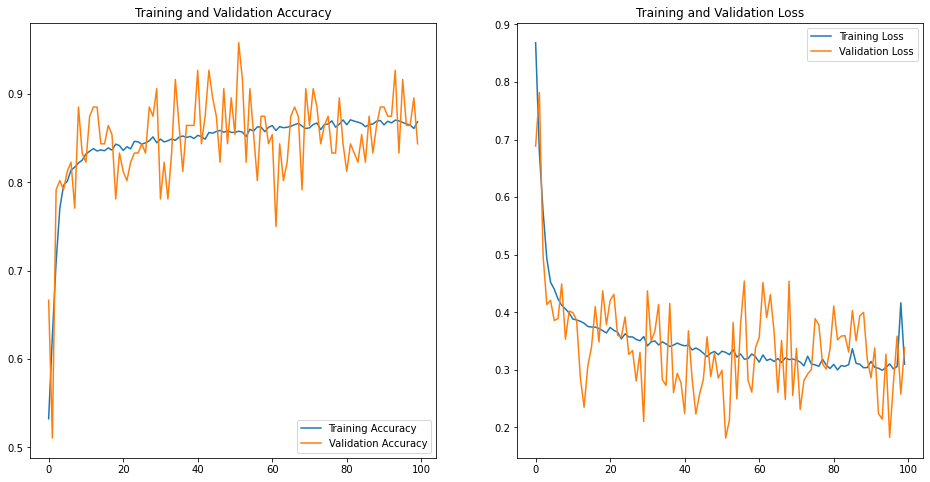

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))  # range for the number of epochs

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('./plots-v2.png')
plt.show()